In [1]:
import keras
import theano
import numpy as np
import pandas as pd
import load_data
import SimpleITK

Using Theano backend.


In [2]:
np.random.seed(42) #Make sure results can be reproduced
from keras.models import Sequential #Feed forward?
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils

### Load labels CSV

In [3]:
labels = pd.read_csv('stage1_labels.csv')
labels.head(2)

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0


In [4]:
labels[labels['id']=='0a0c32c9e08cc2ea76a71649de56be6d']

,id,cancer
57,0a0c32c9e08cc2ea76a71649de56be6d,0


## Load a sample patient and the related images

In [5]:
patient1 = load_data.remove_noise(load_data.load_images('0a0c32c9e08cc2ea76a71649de56be6d'))

In [8]:
reshape_patient1 = load_data.reshape_image(patient1) 

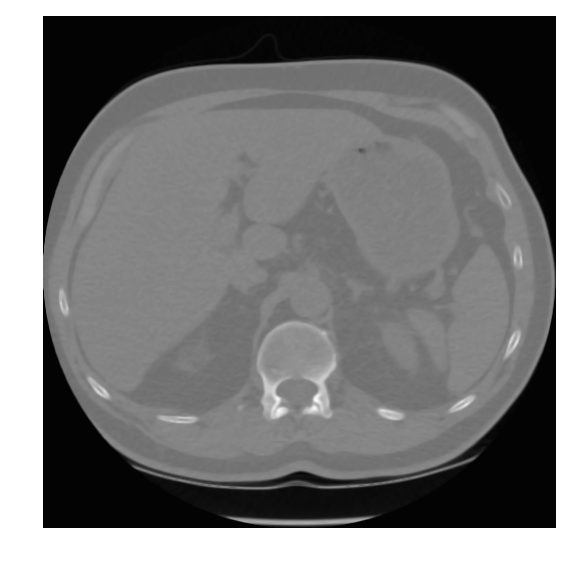

In [10]:
load_data.sitk_show(patient1[:,:,0], dpi=100)

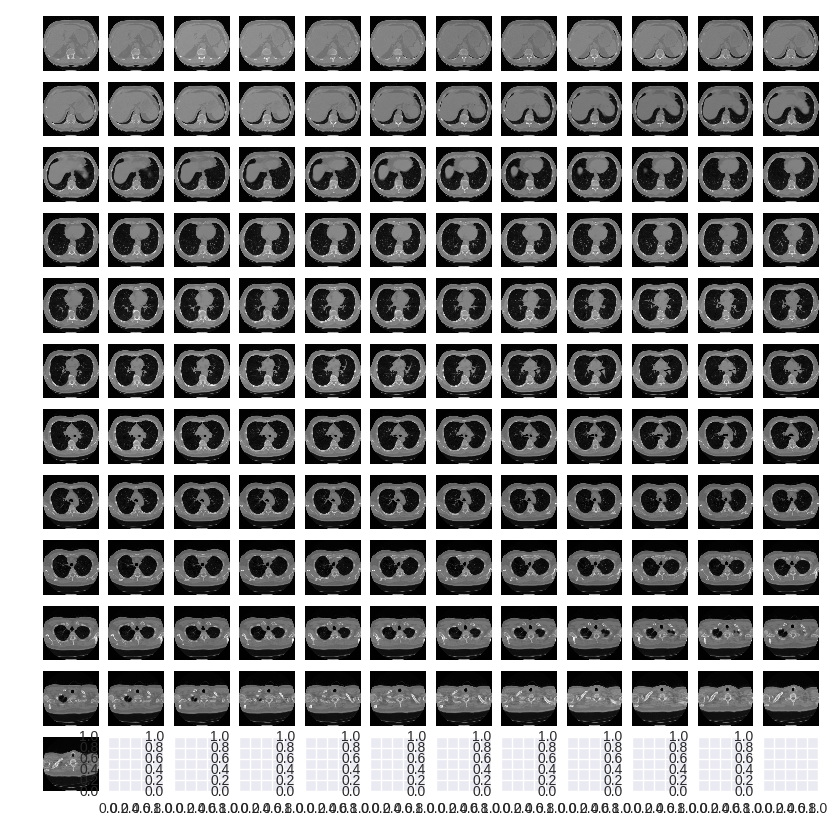

In [8]:
%matplotlib inline
load_data.sitk_show_slices(patient1)

In [11]:
patient1.GetSize()

(512, 512, 133)

In [15]:
patient_1_array = SimpleITK.GetArrayFromImage(patient1)

## Train Keras using 1 sample ( I know it's not the best)

In [16]:
patient_1_array.shape

(133, 512, 512)

In [18]:
X_train = patient_1_array.reshape(1,1,133,512,512)
X_train.shape

(1, 1, 133, 512, 512)

In [29]:
y_train = np.array([1,0])
y_train = y_train.reshape(-1,2)

In [135]:
model = Sequential()
model.add(Convolution3D(8,10,160,160, activation='relu',input_shape=(1,133,512,512),dim_ordering='th'))

In [136]:
model.output_shape

(None, 8, 124, 353, 353)

In [137]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution3d_45 (Convolution3D) (None, 8, 124, 353, 352048008     convolution3d_input_19[0][0]     
Total params: 2048008
____________________________________________________________________________________________________


In [138]:
model.add(Convolution3D(8,10,100,100,activation='relu',dim_ordering='th'))
print model.output_shape
model.add(MaxPooling3D(pool_size=(4,4,4))) # Reduce number of parameters
print model.output_shape
model.add(Convolution3D(8,4,50,50,activation='relu',dim_ordering='th'))
print model.output_shape
model.add(MaxPooling3D(pool_size=(4,4,4))) # Reduce number of parameters
print model.output_shape
model.add(Dropout(0.25)) # Regularised the model to prevent overfit
print model.output_shape
# Now we have 2x conv + 1 maxpool + 1 dropout
model.add(Flatten()) #Must flattern to pass into dense
print model.output_shape
model.add(Dense(1280, activation='relu')) # 
print model.output_shape
model.add(Dropout(0.5))
print model.output_shape
model.add(Dense(2, activation='softmax')) # 10 ouput matches y
print model.output_shape

(None, 8, 115, 254, 254)
(None, 8, 28, 63, 63)
(None, 8, 25, 14, 14)
(None, 8, 6, 3, 3)
(None, 8, 6, 3, 3)
(None, 432)
(None, 1280)
(None, 1280)
(None, 2)


### Note on number of parameters

Apparently it is very easy to generate too many parameters when we are trying to create the model. With a picture of 512 x 512 px and over 100 frame per patient. Number of features can reach over 10e9. This would cause numpy the give up and throw a MemoryError. This mainly happens after the flatten layer. Therefore my guess would be numpy array is restricted to a certain length. There are 3 obvious options to solve this problem.

1. Reduce image size
2. Add more convolution layers
3. Adjust the size of the receptive field (i.e. the size of the sliding window)
4. Adjust the pool size when performing MaxPooling

Point one could be done in the image processing step. However the nodules that we are trying to find being extremely small, I am not sure whether simpy reducing the image size is a good idea.

Point 2 is easy to achieve (to a certain extend). However it adds quite a bit of computational overhead to the model. It might also cause overfitting? 

Point 3 is an interesting method to look at. This is because the size of the receptive field directly imapcts what we can pick up from the image. Too big a field we might fail to activate any neuron (This again depends on yet another parameter which is the number of filters). Too small a field we will pick up many minute details which requires many layers to achieve a high level view. This brings us back to point 2.

Point 4....I am yet to find out what is MaxPooling.

Conclusion in the mean time. It seems that memory plays a critical role in this model. We can try to strike a balance between field size and number of conv layers to get around this. If we have time we might want to find out whether this memory limitation was imposed by my PC (8GB RAM) or numpy itself.

In [139]:
from keras import backend as K
K.set_image_dim_ordering('th')

In [140]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [143]:
model.fit(X_train,y_train)

Epoch 1/10


RuntimeError: CorrMM failed to allocate working memory of 25600 x 124609

Apply node that caused the error: CorrMM{valid, (1, 1)}(Reshape{4}.0, Subtensor{::, ::, ::int64, ::int64}.0)
Toposort index: 101
Inputs types: [TensorType(float32, 4D), TensorType(float32, 4D)]
Inputs shapes: [(133, 1, 512, 512), (80, 1, 160, 160)]
Inputs strides: [(1048576, 1048576, 2048, 4), (102400, 102400, -640, -4)]
Inputs values: ['not shown', 'not shown']
Outputs clients: [[Reshape{6}(CorrMM{valid, (1, 1)}.0, MakeVector{dtype='int64'}.0)]]

Backtrace when the node is created(use Theano flag traceback.limit=N to make it longer):
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/models.py", line 280, in add
    layer.create_input_layer(batch_input_shape, input_dtype)
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 370, in create_input_layer
    self(x)
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 514, in __call__
    self.add_inbound_node(inbound_layers, node_indices, tensor_indices)
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 572, in add_inbound_node
    Node.create_node(self, inbound_layers, node_indices, tensor_indices)
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/engine/topology.py", line 149, in create_node
    output_tensors = to_list(outbound_layer.call(input_tensors[0], mask=input_masks[0]))
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/layers/convolutional.py", line 1218, in call
    filter_shape=self.W_shape)
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py", line 1395, in conv3d
    dim_ordering, volume_shape, filter_shape)
  File "/home/ricky/anaconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py", line 1466, in _old_theano_conv3d
    border_mode=border_mode_3d)

HINT: Use the Theano flag 'exception_verbosity=high' for a debugprint and storage map footprint of this apply node.

In [91]:
print X_train.max()
print X_train.min()

-1051.9204179385993

In [88]:
y_train.shape

(1, 2)

In [142]:
X_train = X_train/X_train.max()*255

# Use resized samples

In [1]:
import keras
import theano
import numpy as np
import pandas as pd
import load_data
import SimpleITK
np.random.seed(42) #Make sure results can be reproduced
from keras.models import Sequential #Feed forward?
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Convolution3D, MaxPooling3D
from keras.utils import np_utils
labels = pd.read_csv('stage1_labels.csv')
labels.head(2)

Using Theano backend.


,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0


In [4]:
patient1 = load_data.get_lungs_arr('0a0c32c9e08cc2ea76a71649de56be6d',path='patient_image/')

In [5]:
globals().keys()

['_dh',
 '__',
 'Dense',
 'labels',
 '__builtin__',
 'Sequential',
 'quit',
 'Dropout',
 '_i4',
 '_i3',
 '_i2',
 '_i1',
 '__package__',
 'patient1',
 'exit',
 'get_ipython',
 '_i',
 'np',
 '__doc__',
 'Activation',
 'pd',
 'keras',
 '__builtins__',
 '_ih',
 '_i5',
 'SimpleITK',
 '__name__',
 '___',
 '_',
 '_sh',
 'Convolution3D',
 'load_data',
 'np_utils',
 '_1',
 'MaxPooling3D',
 '_iii',
 'Flatten',
 '_ii',
 'In',
 'theano',
 '_oh',
 'Out']

In [7]:
X_train = patient1.reshape(1,1,64,64,64)
X_train.shape

(1, 1, 64, 64, 64)

In [8]:
y_train = np.array([1,0])
y_train = y_train.reshape(-1,2)

In [9]:
model = Sequential()
model.add(Convolution3D(8,10,10,10, activation='relu',input_shape=(1,64,64,64),dim_ordering='th'))
model.output_shape

(None, 8, 55, 55, 55)

In [10]:
model.add(Convolution3D(8,10,10,10,activation='relu',dim_ordering='th'))
print model.output_shape
model.add(MaxPooling3D(pool_size=(2,2,2))) # Reduce number of parameters
print model.output_shape
model.add(Convolution3D(8,5,5,5,activation='relu',dim_ordering='th'))
print model.output_shape
model.add(MaxPooling3D(pool_size=(2,2,2))) # Reduce number of parameters
print model.output_shape
model.add(Dropout(0.25)) # Regularised the model to prevent overfit
print model.output_shape
# Now we have 2x conv + 1 maxpool + 1 dropout
model.add(Flatten()) #Must flattern to pass into dense
print model.output_shape
model.add(Dense(128, activation='relu')) # 
print model.output_shape
model.add(Dropout(0.5))
print model.output_shape
model.add(Dense(2, activation='softmax')) # 10 ouput matches y
print model.output_shape

(None, 8, 46, 46, 46)
(None, 8, 23, 23, 23)
(None, 8, 19, 19, 19)
(None, 8, 9, 9, 9)
(None, 8, 9, 9, 9)
(None, 5832)
(None, 128)
(None, 128)
(None, 2)


In [11]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [12]:
model.fit(X_train,y_train)

Epoch 1/10
1/1 [==============================] - 2s - loss: 0.3885 - acc: 1.0000
Epoch 2/10
1/1 [==============================] - 2s - loss: 0.0113 - acc: 1.0000
Epoch 3/10
1/1 [==============================] - 2s - loss: 5.9605e-07 - acc: 1.0000
Epoch 4/10
1/1 [==============================] - 2s - loss: 1.1921e-07 - acc: 1.0000
Epoch 5/10
1/1 [==============================] - 2s - loss: 1.1921e-07 - acc: 1.0000
Epoch 6/10
1/1 [==============================] - 3s - loss: 1.1921e-07 - acc: 1.0000
Epoch 7/10
1/1 [==============================] - 2s - loss: 1.1921e-07 - acc: 1.0000
Epoch 8/10
1/1 [==============================] - 3s - loss: 1.1921e-07 - acc: 1.0000
Epoch 9/10
1/1 [==============================] - 2s - loss: 1.1921e-07 - acc: 1.0000
Epoch 10/10
1/1 [==============================] - 2s - loss: 1.1921e-07 - acc: 1.0000


In [13]:
f = open('items_in_directory.txt','r').read()
print f

0a0c32c9e08cc2ea76a71649de56be6d
0a38e7597ca26f9374f8ea2770ba870d
Image processing.ipynb
items_in_directory.txt
Keras_convolution_3d.ipynb
Keras_tutorial.ipynb
load_data.py
load_data.pyc
README.md
stage1_labels.csv



In [15]:
f_lst = f.strip().split('\n')
for i in f_lst:
    print i

0a0c32c9e08cc2ea76a71649de56be6d
0a38e7597ca26f9374f8ea2770ba870d
Image processing.ipynb
items_in_directory.txt
Keras_convolution_3d.ipynb
Keras_tutorial.ipynb
load_data.py
load_data.pyc
README.md
stage1_labels.csv


In [19]:
import os
os.listdir('.')

['stage1_labels.csv',
 'items_in_directory.txt',
 '.gitignore',
 '0a0c32c9e08cc2ea76a71649de56be6d',
 'Keras_convolution_3d.ipynb',
 'Keras_tutorial.ipynb',
 '.git',
 'README.md',
 '.ipynb_checkpoints',
 '0a38e7597ca26f9374f8ea2770ba870d',
 'load_data.py',
 'Image processing.ipynb',
 'load_data.pyc']